## 감정 분석(Sentiment Analysis)
+ 감정 분석은 텍스트에 등장하는 단어들을 통해 어떤 감정이 드러나는지 분석하는 기법
+ 감정 분석은 오피니언 마이닝으로도 불리며, 텍스트에 담긴 의견, 태도 등을 알아보는데 유용한 기법
+ 감정 분석을 하기 위해선 미리 정의된 감정 어휘 사전이 필요
+ 감정 어휘 사전에 포함된 어휘가 텍스트에 얼마나 분포하는지에 따라 해당 텍스트의 감정이 좌우함
+ 토픽 모델링이 텍스트의 주제를 찾아낸다면, 감정 분석은 텍스트의 의견을 찾아냄
+ 텍스트는 주제(토픽)와 의견(감정)의 결합으로 이루어졌다고 볼 수 있음
+ 감정 분석은 SNS, 리뷰 분석에 유용하게 사용할 수 있음
+ 특정 이슈에 대한 사람들의 감정을 실시간으로 분석한다면, 그에 대해 신속하게 대처 가능


* 파이썬으로 감정 분석하는 방법은 크게 두 가지로 구분
  + 감정 어휘 사전을 이용한 감정 상태 분류
    -  미리 분류해둔 감정어 사전을 통해 분석하고자 하는 텍스트의 단어들을 사전에 기반해 분류하고, 그 감정가를 계산
    - 이 때 사용되는 감정어 사전에는 해당 감정에 해당되는 단어를 미리 정의해둬야 함
  + 기계학습을 이용한 감정 상태 분류
    - 분석 데이터의 일부를 훈련 데이터로 사용해 그로부터 텍스트의 감정 상태를 분류
    - 이 때 사용되는 훈련 데이터는 사용자가 분류한 감정 라벨이 포함되어 있어야 하며,  
이를 인공 신경망, 의사 결정 트리 등의 기계 학습 알고리즘을 사용하여 분류

### 1. 감정 어휘 사전을 이용한 감정 상태 분류

In [32]:
#감정 사전 준비(afinn : 영어에 대한 긍/부정 감정사전 제공)
#!pip install afinn

#데이터 준비
from sklearn.datasets import fetch_20newsgroups

newsdata = fetch_20newsgroups(subset='train')
newsdata.data[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [33]:
from afinn import Afinn

afinn = Afinn()     #감정사전 구성
for i in range(3):
    print(afinn.score(newsdata.data[i]))    #뉴스별 감정점수

7.0
11.0
16.0


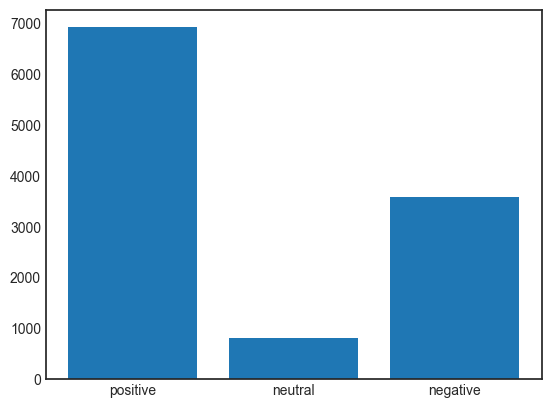

In [34]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

#긍정/중립/부정 개수 시각화
positive = 0
neutral = 0
negative = 0

for i in newsdata.data:
    score = afinn.score(i)
    if score > 0:
        positive += 1
    elif score == 0:
        neutral += 1
    else :
        negative += 1

plt.bar(np.arange(3), [positive, neutral, negative])
plt.xticks(np.arange(3), ['positive', 'neutral', 'negative']);

### 2. 기계학습을 이용한 감정분석

#### 1. 네이버 영화 리뷰 데이터

In [35]:
#데이터 준비
import urllib.request
import pandas as pd

train_file = urllib.request.urlopen('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')
test_file = urllib.request.urlopen('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt')

train_data = pd.read_table(train_file)
test_data = pd.read_table(test_file)

print(len(train_data), len(test_data))
train_data.head(3)

150000 50000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [36]:
#전처리
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data['document'] = train_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')
train_data['document'].replace('', np.nan, inplace=True)
train_data = train_data.dropna(how='any')

print(len(train_data))

145791


In [37]:
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data['document'] = test_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')
test_data['document'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')

print(len(test_data))

48995


In [38]:
#불용어 제거
from konlpy.tag import Mecab

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
mecab = Mecab('C:\mecab\mecab-ko-dic')

X_train, X_test = [], []
for sentence in train_data['document']:
    X_train.append([word for word in mecab.morphs(sentence) if not word in stopwords])
for sentence in test_data['document']:
    X_test.append([word for word in mecab.morphs(sentence) if not word in stopwords])
    
print(X_train[:3]) 

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나'], ['너무', '재', '밓었다그래서보는것을추천한다']]


In [39]:
#토큰화
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [40]:
#빈도수 낮은 단어 제거
threshold = 3
words_cnt = len(tokenizer.word_index)
rare_cnt = 0
words_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    words_freq = words_freq + value
    if value < threshold :
        rare_cnt += 1
        rare_freq = rare_freq + value
        
print('전체 단어 수:', words_cnt)
print('빈도가 {} 이하인 희귀 단어 수 : {}'.format(threshold-1, rare_cnt))
print('희귀 단어 비율 : {}'.format(rare_cnt/words_cnt*100))
print('희귀 단어 등장 빈도 비율 : {}'.format((rare_freq/words_freq)*100))

전체 단어 수: 49946
빈도가 2 이하인 희귀 단어 수 : 28320
희귀 단어 비율 : 56.70123733632323
희귀 단어 등장 빈도 비율 : 1.7606788534131563


In [41]:
vocab_size = words_cnt - rare_cnt + 2 #(0번째 padding, out of vocabulary token) = 2

print(vocab_size) 

21628


In [42]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_train = np.delete(X_train, drop_train, axis = 0)
y_train = np.delete(y_train, drop_train, axis = 0)

print(len(X_train))

145380


c:\Users\yeonok\.conda\envs\nlp\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


리뷰 최대 길이 : 83
리뷰 평균 길이 : 13.80136194799835


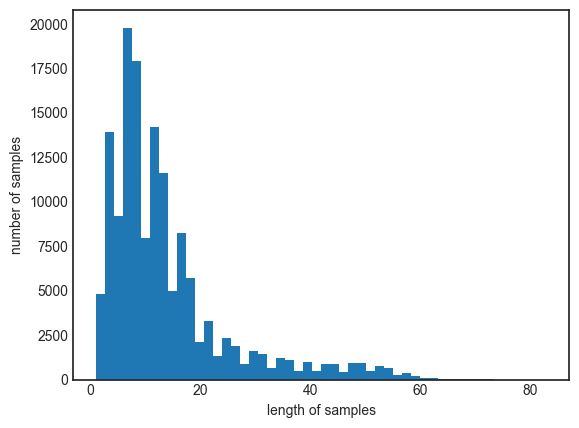

In [43]:
#padding 위해 길이 분포 확인
print('리뷰 최대 길이 :', max(len(l) for l in X_train))
print('리뷰 평균 길이 :', sum(map(len, X_train)) / len(X_train))

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples');

In [44]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 60
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [45]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential

model = Sequential([Embedding(vocab_size, 100),
                    LSTM(128),
                    Dense(1, activation='sigmoid')])

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         2162800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,280,177
Trainable params: 2,280,177
Non-trainable params: 0
_________________________________________________________________


In [46]:
history = model.fit(X_train, y_train, epochs=10, 
                    batch_size=64, validation_split=0.2)

Train on 116304 samples, validate on 29076 samples
Epoch 1/10
116304/116304 [==============================] - 124s 1ms/sample - loss: 0.3876 - acc: 0.8257 - val_loss: 0.3565 - val_acc: 0.8442
Epoch 2/10
116304/116304 [==============================] - 124s 1ms/sample - loss: 0.3190 - acc: 0.8625 - val_loss: 0.3308 - val_acc: 0.8587
Epoch 3/10
116304/116304 [==============================] - 119s 1ms/sample - loss: 0.2914 - acc: 0.8772 - val_loss: 0.3248 - val_acc: 0.8599
Epoch 4/10
116304/116304 [==============================] - 120s 1ms/sample - loss: 0.2714 - acc: 0.8878 - val_loss: 0.3158 - val_acc: 0.8661
Epoch 5/10
116304/116304 [==============================] - 118s 1ms/sample - loss: 0.2549 - acc: 0.8962 - val_loss: 0.3166 - val_acc: 0.8658
Epoch 6/10
116304/116304 [==============================] - 117s 1ms/sample - loss: 0.2404 - acc: 0.9037 - val_loss: 0.3175 - val_acc: 0.8651
Epoch 7/10
116304/116304 [==============================] - 113s 970us/sample - loss: 0.2257 - ac

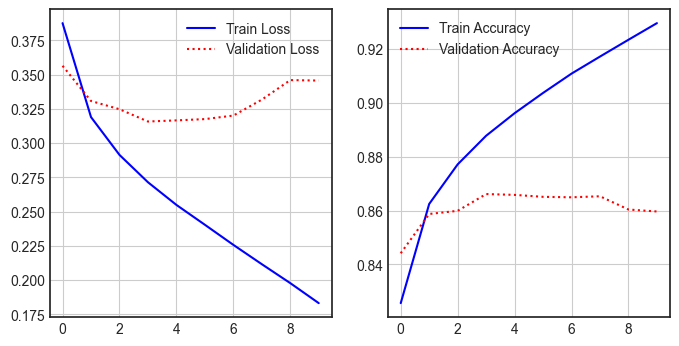

In [47]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label='Train Loss')
plt.plot(history.history['val_loss'], 'r:', label='Validation Loss')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['acc'], 'b-', label='Train Accuracy')
plt.plot(history.history['val_acc'], 'r:', label='Validation Accuracy')
plt.legend()
plt.grid();

In [48]:
model.evaluate(X_test, y_test)

48995/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.3544951654001211, 0.85504645]

In [49]:
#새로운 데이터로 감정예측
def sentiment_predict(new_sentence):
    new_token = [word for word in mecab.morphs(new_sentence) if word not in stopwords]
    new_sequences = tokenizer.texts_to_sequences([new_token])
    new_pad = pad_sequences(new_sequences, maxlen=max_len)
    score=float(model.predict(new_pad))
    
    if score > 0.5:
        print("{} -> 긍정({:.2f}%)".format(new_sentence, score*100))
    else:
        print("{} -> 부정({:.2f}%)".format(new_sentence, (1-score)*100))
        
sentiment_predict('정말 재미있고 흥미진진 했어요.')
sentiment_predict('어떻게 이렇게 지루하고 재미없죠?')
sentiment_predict('분위기가 어둡고 스토리가 어려워요')
sentiment_predict('배우 연기력이 대박입니다')

정말 재미있고 흥미진진 했어요. -> 긍정(98.62%)
어떻게 이렇게 지루하고 재미없죠? -> 부정(99.83%)
분위기가 어둡고 스토리가 어려워요 -> 긍정(54.25%)
배우 연기력이 대박입니다 -> 긍정(96.69%)


#### 2. 네이버 쇼핑 리뷰 데이터

In [50]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="shopping.txt")
data = pd.read_table('shopping.txt', names=['ratings', 'reviews'])

data = data.drop_duplicates(subset=['reviews'])
data = data.dropna(how='any')

print(len(data))
data.head(3)

199908


,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...


<AxesSubplot:>

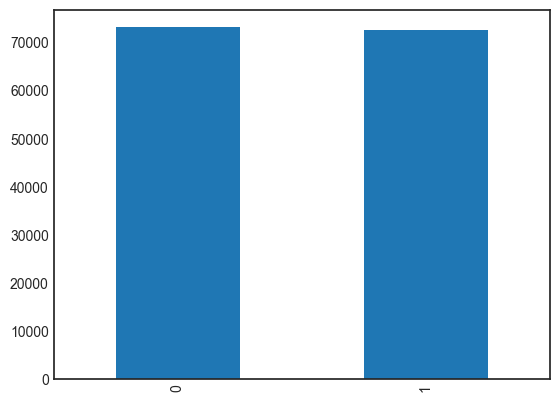

In [51]:
# 라벨링(3점 넘으면 1, 그 외 0)
data['label'] = np.select([data.ratings > 3], [1], default=0)

train_data['label'].value_counts().plot(kind='bar')

In [52]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.25, random_state=111)
print(len(train_data), len(test_data))

149931 49977


In [53]:
train_data['reviews'] = train_data['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')
train_data['reviews'].replace('', np.nan, inplace=True)
print(len(train_data))

test_data['reviews'] = test_data['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')
test_data['reviews'].replace('', np.nan, inplace=True)
print(len(test_data)) 

149931
49977


In [55]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']
mecab = Mecab('C:\mecab\mecab-ko-dic')

train_data['reviews'] =  train_data['reviews'].apply(mecab.morphs)
train_data['reviews'] =  train_data['reviews'].apply(lambda x : [item for item in x if item not in stopwords])
test_data['reviews'] =  test_data['reviews'].apply(mecab.morphs)
test_data['reviews'] =  test_data['reviews'].apply(lambda x : [item for item in x if item not in stopwords])

X_train = train_data['reviews'].values
y_train = train_data['label'].values
X_test = test_data['reviews'].values
y_test = test_data['label'].values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(149931,) (149931,) (49977,) (49977,)


In [56]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
threshold = 3
words_cnt = len(tokenizer.word_index)
rare_cnt = 0
words_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    words_freq = words_freq + value
    if value < threshold :
        rare_cnt += 1
        rare_freq = rare_freq + value
        
print('전체 단어 수:', words_cnt)
print('빈도가 {} 이하인 희귀 단어 수 : {}'.format(threshold-1, rare_cnt))
print('희귀 단어 비율 : {}'.format(rare_cnt/words_cnt*100))
print('희귀 단어 등장 빈도 비율 : {}'.format((rare_freq/words_freq)*100))

전체 단어 수: 40060
빈도가 2 이하인 희귀 단어 수 : 23111
희귀 단어 비율 : 57.690963554667995
희귀 단어 등장 빈도 비율 : 1.218032308269993


In [57]:
vocab_size = words_cnt - rare_cnt + 2
print(vocab_size) 

16951


In [58]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

리뷰 최대 길이 : 85
리뷰 평균 길이 : 15.329031354423035


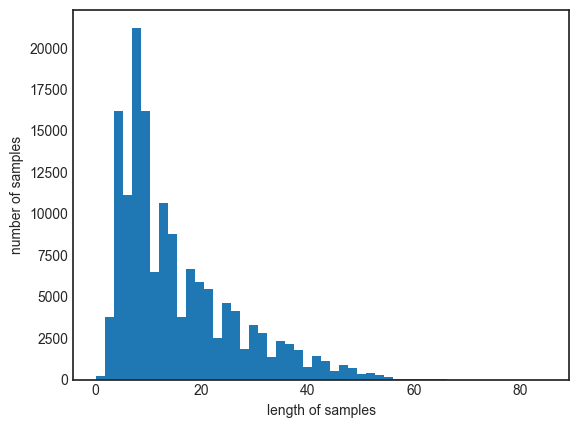

In [59]:
print('리뷰 최대 길이 :', max(len(l) for l in X_train))
print('리뷰 평균 길이 :', sum(map(len, X_train)) / len(X_train))

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples');

In [60]:
max_len = 60
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [61]:
from tensorflow.keras.layers import GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential([Embedding(vocab_size, 100),
                    GRU(128),
                    Dense(1, activation='sigmoid')])

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1695100   
_________________________________________________________________
gru (GRU)                    (None, 128)               88320     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,783,549
Trainable params: 1,783,549
Non-trainable params: 0
_________________________________________________________________


In [62]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('naver_review_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Train on 119944 samples, validate on 29987 samples
Epoch 1/15
119936/119944 [============================>.] - ETA: 0s - loss: 0.2696 - acc: 0.8980
Epoch 00001: val_acc improved from -inf to 0.90743, saving model to naver_review_best_model.h5
119944/119944 [==============================] - 110s 913us/sample - loss: 0.2696 - acc: 0.8980 - val_loss: 0.2444 - val_acc: 0.9074
Epoch 2/15
119936/119944 [============================>.] - ETA: 0s - loss: 0.2142 - acc: 0.9221
Epoch 00002: val_acc improved from 0.90743 to 0.92113, saving model to naver_review_best_model.h5
119944/119944 [==============================] - 110s 917us/sample - loss: 0.2143 - acc: 0.9221 - val_loss: 0.2210 - val_acc: 0.9211
Epoch 3/15
119936/119944 [============================>.] - ETA: 0s - loss: 0.1969 - acc: 0.9284
Epoch 00003: val_acc improved from 0.92113 to 0.92320, saving model to naver_review_best_model.h5
119944/119944 [==============================] - 111s 925us/sample - loss: 0.1969 - acc: 0.9284 - val

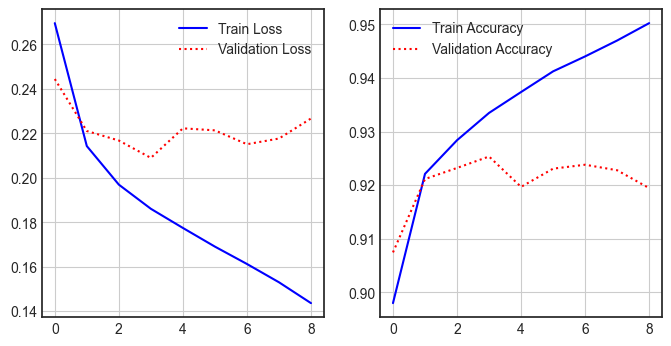

In [63]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label='Train Loss')
plt.plot(history.history['val_loss'], 'r:', label='Validation Loss')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['acc'], 'b-', label='Train Accuracy')
plt.plot(history.history['val_acc'], 'r:', label='Validation Accuracy')
plt.legend()
plt.grid();

In [72]:
from tensorflow.keras.models import load_model

loaded_model = load_model('naver_review_best_model.h5')

loaded_model.evaluate(X_test, y_test)

49977/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.22475443817423912, 0.92178404]

In [74]:
def sentiment_predict(new_sentence):
    new_token = [word for word in mecab.morphs(new_sentence) if word not in stopwords]
    new_sequences = tokenizer.texts_to_sequences([new_token])
    new_pad = pad_sequences(new_sequences, maxlen=max_len)
    score=float(loaded_model.predict(new_pad))
    
    if score > 0.5:
        print("{} -> 긍정({:.2f}%)".format(new_sentence, score*100))
    else:
        print("{} -> 부정({:.2f}%)".format(new_sentence, (1-score)*100))
        
sentiment_predict('처음 써봤는데 대박 좋아요.')
sentiment_predict('원래 배송이 이렇게 늦나요?')
sentiment_predict('좋은 거 인정! 추가 구매 의향 있습니다.')
sentiment_predict('이건 정말 리뷰 쓰는 게 아깝네요.')

처음 써봤는데 대박 좋아요. -> 긍정(98.71%)
원래 배송이 이렇게 늦나요? -> 부정(98.76%)
좋은 거 인정! 추가 구매 의향 있습니다. -> 긍정(96.89%)
이건 정말 리뷰 쓰는 게 아깝네요. -> 부정(97.53%)
